# MNIST for TF Lite for micro controllers

***

## Model

In [0]:
import tensorflow as tf

In [2]:
print('TensorFlow version: ', tf.__version__)

TensorFlow version:  1.14.0-rc1


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

- https://stackoverflow.com/questions/53249386/valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4-found

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3,3), strides=(2,2), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(6, (3,3), strides=(2,2), activation='relu'),
    tf.keras.layers.Flatten(input_shape=(32, 7, 7)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

#     tf.keras.layers.Reshape((28,28,1)),

W0628 10:45:45.897986 140693523052416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 6)           222       
_________________________________________________________________
flatten (Flatten)            (None, 216)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               43400     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      
Total params: 45,672
Trainable params: 45,672
Non-trainable params: 0
____________________________________________________

In [9]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
60000/60000 [==============================] - 8s 140us/sample - loss: 0.2792 - acc: 0.9180
Epoch 2/20
60000/60000 [==============================] - 7s 123us/sample - loss: 0.1161 - acc: 0.9646
Epoch 3/20
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0885 - acc: 0.9728
Epoch 4/20
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0727 - acc: 0.9773
Epoch 5/20
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0638 - acc: 0.9799
Epoch 6/20
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0560 - acc: 0.9817
Epoch 7/20
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0489 - acc: 0.9840
Epoch 8/20
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0438 - acc: 0.9853
Epoch 9/20
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0397 - acc: 0.9869
Epoch 10/20
60000/60000 [==============================] - 7s 123us/sampl

- Accuracy:

In [10]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 0.0574 - acc: 0.9842


[0.05737222185545952, 0.9842]

## Create model fot TF Lite micro

In [11]:
model.save('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5' )

W0628 10:48:17.102269 140693523052416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0628 10:48:17.103962 140693523052416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0628 10:48:17.885139 140693523052416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is

In [12]:
tflite_model = converter.convert()
open("model_float.tflite", "wb").write(tflite_model)

184448

In [13]:
!sudo apt-get install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.0.1453-1ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
!xxd -i model_float.tflite > model_float.cc

## Test

In [0]:
import numpy as np

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model_float.tflite")
interpreter.allocate_tensors()

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
# Test model on test data.
y = np.zeros(x_test.shape[0])

input_shape = input_details[0]['shape']

input_data = np.expand_dims( np.array(x_test[0], dtype=np.float32), axis=0 )
interpreter.set_tensor(input_details[0]['index'], input_data)  
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

y = np.argmax(output_data, axis=1)

In [20]:
print('Final output: %d' % y[0])
print(output_data)

Final output: 7
[[1.11092004e-11 8.06480228e-15 1.88968641e-09 3.40899433e-08
  1.40474485e-14 1.13910187e-10 1.89211557e-22 1.00000000e+00
  6.73124967e-12 4.93871291e-08]]


## Visualize

In [0]:
from  matplotlib import pyplot 

Text(0.5, 1.0, '7')

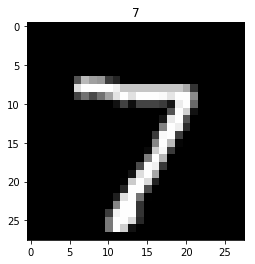

In [22]:
pyplot.imshow(x_test[0].reshape(28, 28), cmap='gray')
pyplot.title(y[0])